In [ ]:
#|default_exp ffcv.inference

In [ ]:
#|exporti
# Contains code from:
# fastai - Apache License 2.0 - Copyright (c) 2023 fast.ai
# FFCV - Apache License 2.0 - Copyright (c) 2022 FFCV Team

# FFCV Inference Using fastai
> fastai DataBlock items for use with `Loader` trained models

FFCV is currently hardcoded to use OpenCV's `INTER_AREA` when resizing images, while fastai uses Pillow.

This module provides OpenCV versions of fastai DataBlock items, prefixed with FFAI, for inference after training with `Loader`.

In [ ]:
#|export
from __future__ import annotations

import cv2
import torch
import numpy as np
from PIL import Image

from fastcore.basics import Path, merge
from fastcore.transform import DisplayedTransform

from fastai.data.block import TransformBlock
from fastai.data.transforms import IntToFloatTensor, ToTensor
from fastai.vision.core import image2tensor

from fastxtend.utils import pil_to_numpy
from fastxtend.imports import *

In [ ]:
#|hide
from fastxtend.test_utils import *

## FFAI Image Loading

`FFAIBase` is the OpenCV version of `fastai.vision.core.PILBase`. It uses OpenCV for image loading and type dispatch transforms.

Unlike OpenCV, these images load in RGB format.

In [ ]:
#|exporti
def load_image(fn:str|Path, mode=None):
    "Open and load an image with OpenCV, optionally converting to `mode` and RGB order"
    if isinstance(fn, Path):
        fn = str(fn)
    if mode is None:
        return cv2.imread(fn)
    else:
        if mode == cv2.IMREAD_COLOR:
            return cv2.cvtColor(cv2.imread(fn, mode), cv2.COLOR_BGR2RGB)
        else:
            return cv2.imread(fn, mode)

In [ ]:
#|export
class FFAIBase(np.ndarray):
    "Base class for a FFCV image that can show itself and convert to a Tensor"
    # _bypass_type = np.ndarray
    _show_args = {'cmap':'viridis'}
    _open_args = {'mode': cv2.IMREAD_COLOR }

    @classmethod
    def create(cls, fn:Path|str|Tensor|np.ndarray|Image.Image, **kwargs):
        "Return an Image from `fn`"
        if isinstance(fn, TensorImage):
            fn = fn.permute(1,2,0).type(torch.uint8)
        if isinstance(fn, TensorMask):
            fn = fn.type(torch.uint8)
        if isinstance(fn, Tensor):
            fn = fn.numpy()
        if isinstance(fn, np.ndarray):
            return cls(fn)
        if isinstance(fn, Image.Image):
            return cls(pil_to_numpy(fn))
        return cls(load_image(fn, **merge(cls._open_args, kwargs)))

    def show(self, ctx=None, **kwargs):
        "Show image using `merge(self._show_args, kwargs)`"
        return show_image(self, ctx=ctx, **merge(self._show_args, kwargs))

    def __new__(cls, input_array):
        obj = np.asarray(input_array).view(cls)
        return obj

    def __array_finalize__(self, obj):
        if obj is None: return

    def __repr__(self):
        return f'{self.__class__.__name__} shape={"x".join([str(d) for d in self.shape])}'

In [ ]:
#|export
class FFAIImage(FFAIBase):
    "A RGB FFCV image that can show itself and converts to `TensorImage`"
    _tensor_cls = TensorImage

Unlike OpenCV images, FFCV images and `FFAIImage` are in RGB format.

In [ ]:
#|export
class FFAIImageBW(FFAIBase):
    "A BW FFCV image that can show itself and converts to `TensorImageBW`"
    _show_args = {'cmap':'Greys'}
    _open_args = {'mode': cv2.IMREAD_GRAYSCALE}
    _tensor_cls = TensorImageBW

In [ ]:
#|hide
im = FFAIImage.create(TEST_IMAGE)
test_eq(type(im), FFAIImage)
test_eq(im.__repr__(), 'FFAIImage shape=803x1200x3')

<Axes: >

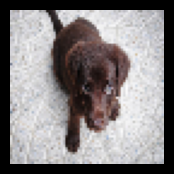

In [ ]:
#|hide
FFAIImage(cv2.resize(im, (64,64))).show()

In [ ]:
#|hide
timg = TensorImage(image2tensor(im))
tocv = FFAIImage.create(timg)
test_eq(im, tocv)

In [ ]:
#|export
class FFAIMask(FFAIBase):
    "A FFCV image mask that can show itself and converts to `TensorMask`"
    _show_args = {'cmap':'Greys'}
    _open_args = {'mode': cv2.IMREAD_GRAYSCALE}
    _tensor_cls = TensorMask

In [ ]:
#|hide
im = FFAIMask.create(TEST_IMAGE)
test_eq(type(im), FFAIMask)
test_eq(im.__repr__(), 'FFAIMask shape=803x1200')

In [ ]:
#|export
@ToTensor
def encodes(self, o:FFAIBase):
    return o._tensor_cls(image2tensor(o))

@ToTensor
def encodes(self, o:FFAIMask):
    return o._tensor_cls(image2tensor(o)[0])

Any data augmentation transform that runs on FFAI Images must be run before the `fastai.data.transform.ToTensor` transform, which has an order of 5.

In [ ]:
#|hide
tfm = ToTensor()
print(tfm)
print(type(im))
print(type(tfm(im)))

ToTensor:
encodes: (PILMask,object) -> encodes
(PILBase,object) -> encodes
(FFAIMask,object) -> encodes
(FFAIBase,object) -> encodes
decodes: 
<class '__main__.FFAIMask'>
<class 'fastai.torch_core.TensorMask'>


## FFAI ImageBlocks

`FFAIImageBlock` is identical to `fastai.vision.data.ImageBlock` except it uses `FFAIImage` by default.

In [ ]:
#|export
def FFAIImageBlock(cls:FFAIBase=FFAIImage):
    "A `TransformBlock` for images of `cls`"
    return TransformBlock(type_tfms=cls.create, batch_tfms=IntToFloatTensor)

## Basic FFAI Item Transforms

Currently only `FFAICenterCrop` is implemented for inference.

In [ ]:
#|exporti
def get_center_crop(height, width, _, ratio):
    s = min(height, width)
    c = int(ratio * s)
    delta_h = (height - c) // 2
    delta_w = (width - c) // 2

    return delta_h, delta_w, c

In [ ]:
#|export
class FFAICenterCrop(DisplayedTransform):
    split_idx,order = None,1
    "Resize `FFAIBase` image to `output_size` using `ratio`"
    def __init__(self,
        output_size:int, # Square size to resize and crop image to
        ratio:float, # Ratio of (crop size) / (min side length)
        interpolation=(cv2.INTER_AREA, cv2.INTER_NEAREST), # OpenCV interpolation mode, resamples[1] for mask
    ):
        super().__init__()
        assert isinstance(output_size, int), f"{output_size=} must be an int"
        self.size = (output_size, output_size)
        self.ratio = ratio
        self.interp,self.mask_interp = interpolation

    def encodes(self, x:FFAIBase):
        height, width, _ = x.shape
        s = min(height, width)
        c = int(self.ratio * s)
        h = (height - c) // 2
        w = (width - c) // 2
        return cv2.resize(x[h:h+c, w:w+c], self.size, interpolation=self.mask_interp if isinstance(x,FFAIMask) else self.interp)